# **EDA**

El conjunto de datos proporcionados consta de dos grandes conjuntos, por un lado en una carpeta llamada ``train_images`` se encuentran todas las imagenes con las cuales mas adelante se buscará entrenar los distintos modelos de deep learning para la deteccion de cancer de prostata, además se tiene una carpeta titulada ``train_label_mask`` donde se encuentran las mascaras asociada a cada una de las imagen que se mencionaron anteriormente, por ultimo se tienen lo siguientes archivos ``csv``.

1. sample_submission.csv
2. test.csv
3. train.csv


In [11]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.image as mpimg

In [3]:
data=pd.read_csv('C:/Users/fonta/OneDrive/Documentos/CDD/7. Septimo semetre/Deep learning/Proyecto/train.csv')

In [4]:
data.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


In [5]:
data.shape

(10616, 4)

En el resumen anterior se puede apreciar que existen 4 columnas en el dataset, y un total de 10616 registros:

- image_id: Identificador único para cada una de las imagenes.
- data_provider: Entidad que proporcionó las imagenes.
- isup_grade: International Society of Urological Pathology grade.
- gleason_score: Grado de Gleason.

Veamos un pequeño descriptivo de cada una de estas variables.

In [6]:
data.image_id.count()

10616

Notese que cada uno de los id de las imagenes son únicos.

In [7]:
data.data_provider.unique()

array(['karolinska', 'radboud'], dtype=object)

Vemos que existen 2 únicos proveedores de datos.

data_provider
karolinska    5456
radboud       5160
Name: count, dtype: int64


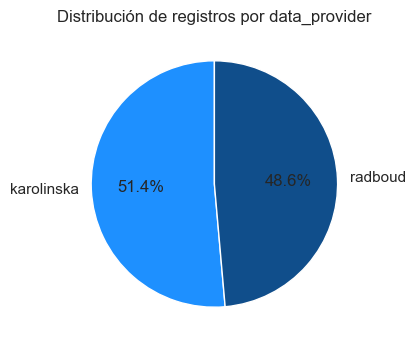

In [5]:
sns.set(style="whitegrid")

data_counts = data['data_provider'].value_counts()
print(data_counts)

plt.figure(figsize=(4, 4))
colors = ['#1E90FF', '#104E8B'] 

plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'white'})

plt.title('Distribución de registros por data_provider')
plt.show()


En el gráfico anterior se muestra la proporción de datos que fueron suministrados por cada uno de los 2 provedores, como se mencionó anteriormente, se tiene un total de 10.616 imagenes y por motivos de recursos computacionales nos vemos en la tarea de reducir la cantidad de datos con la que se trabajarán los modelos, por lo cual mas adelante se tomarán solo los datos provistos por radboud para entrenar los modelos, los que nos deja trabajando con el 49% de los datos totales aproximadamente (5.160). 

**Nota:** recordemos que para cada una de las imagenes, se tiene una mascara asociada que será utilizada para entrenar los modelos, es decir que al final estaremos trabajando con 5.160 imagenes y 5.160 mascaras.

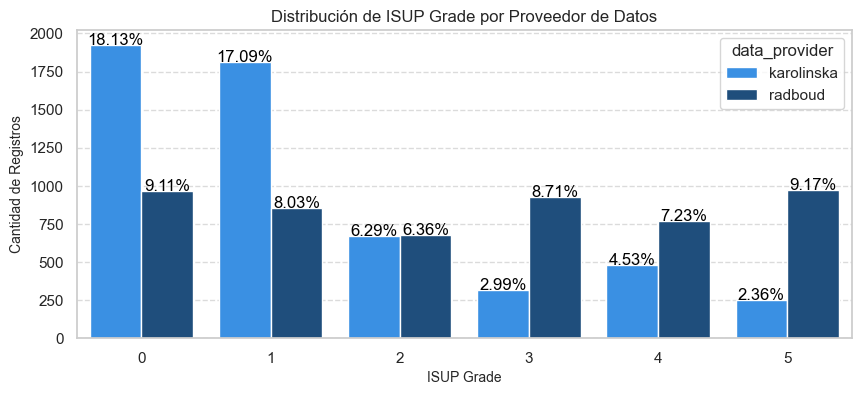

In [ ]:
sns.set(style="whitegrid")

fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=data, palette=colors)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height + 3, 
                '{:1.2f}%'.format(100 * height / len(data)), 
                ha="center", fontsize=12, color='black')

plt.title('Distribución de ISUP Grade por Proveedor de Datos', fontsize=12)
plt.xlabel('ISUP Grade', fontsize=10)
plt.ylabel('Cantidad de Registros', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

En la gráfica anterior se muestra otra de las razones por las cuales al final se trabajará con el subconjunto provisto por radboud, vemos que para esta variable se tiene un balance entre las clases del grado ISUP, lo cual nos ayudará al momento de entrenar los modelos.

## **Subconjunto de datos: Radboud**

In [8]:
data_rad = data[data['data_provider'] == 'radboud']
data_rad=data_rad.drop('data_provider', axis=1,).reset_index(drop=True)
data_rad.head()

,image_id,isup_grade,gleason_score
0,0018ae58b01bdadc8e347995b69f99aa,4,4+4
1,004dd32d9cd167d9cc31c13b704498af,1,3+3
2,0068d4c7529e34fd4c9da863ce01a161,3,4+3
3,006f6aa35a78965c92fffd1fbd53a058,3,4+3
4,007433133235efc27a39f11df6940829,0,negative


In [9]:
data_rad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       5160 non-null   object
 1   isup_grade     5160 non-null   int64 
 2   gleason_score  5160 non-null   object
dtypes: int64(1), object(2)
memory usage: 121.1+ KB


Podemos notar que en este subconjunto de datos cuenta con las mismas variables que el conjunto de datos original, y tiene un totl de 5.160 registros.

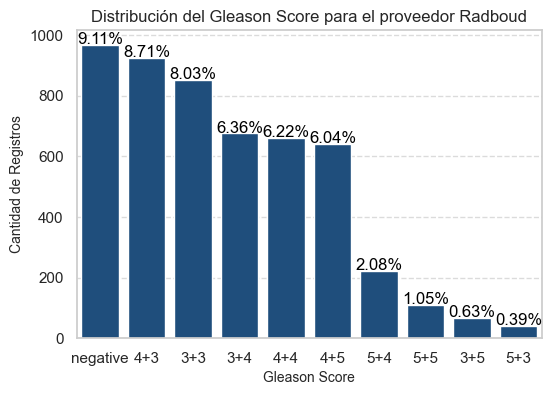

In [10]:
sns.set(style="whitegrid")

# Crear la figura y el gráfico de barras
fig = plt.figure(figsize=(6, 4))
ax = sns.countplot(x="gleason_score", data=data_rad, color="#104E8B", order = data_rad['gleason_score'].value_counts().index)

# Agregar los números sobre las barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height + 3, 
                '{:1.2f}%'.format(100 * height / len(data)), 
                ha="center", fontsize=12, color='black')

# Títulos y etiquetas
plt.title('Distribución del Gleason Score para el proveedor Radboud', fontsize=12)
plt.xlabel('Gleason Score', fontsize=10)
plt.ylabel('Cantidad de Registros', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

En la gráfica se observa la distribución de las clases para la variable Gleason Score, donde se evidencia un desbalance en la cantidad de registros por categoría. En particular, las clases ``5+3`` y ``3+5`` presentan muy pocos casos, lo que indica que en esta muestra la frecuencia de cánceres agresivos es baja. De manera similar, los scores ``5+4`` y ``5+5`` que representan los canceres mas agresivos y estos también muestran una menor representación en comparación con otras categorías.

## **Submuestreo**

Como se mencionó anteriormente, la mayor limitante al momento de trabajar con imagenes, es la cantidad de recursos que se necesitan no solo para procesarlas si no tambien al momento de entrenar los modelos con las mismas, es por esta principal razón que para este estudio nos vimos en la tarea de tomar una muestra mas pequeña, la idea principal es escoger una muestra estratificada, es decir, una muestra donde se mantengan las proporciones para la variable ```Gleason Score```, la explicación detallada de como se llevo a cabo el proceso se encuentra en el apartado de ```Filtro y selección final de las imagenes```.

## **EDA de imagenes**

El Análisis Exploratorio de Datos (EDA) para imágenes es un paso fundamental en la construcción de modelos de visión por computadora y en este caso para tecnicas y modelos de deep learning, ya que permite comprender la distribución, calidad y características de las imágenes antes del entrenamiento. A través de técnicas como la visualización de ejemplos, el análisis de histograma de píxeles, la detección de ruido o anomalías y la evaluación del balance de clases, se pueden identificar posibles problemas que afecten el rendimiento del modelo. Además, el EDA ayuda a definir estrategias de preprocesamiento adecuadas, como normalización, aumento de datos o filtrado de imágenes defectuosas, optimizando así el desempeño del modelo y reduciendo el riesgo de sesgo o sobreajuste.

En esta sección abordaremos el análisis pertinente para las imagenes que hacen parte del conjunto de datos de Radboud.

**Carga de las imagenes**: Para este ejercicio de exploración se tomarán como ejemplo un total de 12 imagen las cuales corresponden a 6 imagenes y a 6 mascaras respectivas a cada una de las imgagenes, cada imagen corresponde a uno de los grados del ISUP score.

In [39]:
#Se escogen las primeras imagenes para cada ISUP score
isup = [0, 1, 2, 3, 4, 5]
id_isup = []

for k in isup:
    filtro = data_rad[data_rad['isup_grade'] == k]
    if not filtro.empty:
        id_isup.append(filtro.iloc[0])

data_isup = pd.DataFrame(id_isup)
print(data_isup)


                            image_id  isup_grade gleason_score
4   007433133235efc27a39f11df6940829           0      negative
1   004dd32d9cd167d9cc31c13b704498af           1           3+3
11  00bbc1482301d16de3ff63238cfd0b34           2           3+4
2   0068d4c7529e34fd4c9da863ce01a161           3           4+3
0   0018ae58b01bdadc8e347995b69f99aa           4           4+4
7   00928370e2dfeb8a507667ef1d4efcbb           5           4+5


En el dataset anterior de encuentran los id de las imagenes de nuestro interés que en el paso siguiente nos ayudara a almacenar estas imagenes en una lista, ademas se encuentra tambien el ```ISUP grade``` y su respectivo `````gleason score`````.

In [14]:
isup_img = []
isup_mask = []

for img_id in data_isup['image_id']:
    # Cargar imagen normal
    ruta_imagen = f"C:/Users/fonta/OneDrive/Documentos/CDD/7. Septimo semetre/Deep learning/py_deeplearning/images_eda/{img_id}.tiff"
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_UNCHANGED)

    # Cargar máscara
    ruta_mascara = f"C:/Users/fonta/OneDrive/Documentos/CDD/7. Septimo semetre/Deep learning/py_deeplearning/images_eda/{img_id}_mask.tiff"
    mascara = cv2.imread(ruta_mascara, cv2.IMREAD_UNCHANGED)
    
    isup_img.append(imagen)
    isup_mask.append(mascara)


print(f"Imágenes cargadas: {len(isup_img)}")
print(f"Máscaras cargadas: {len(isup_mask)}")


Imágenes cargadas: 6
Máscaras cargadas: 6


**Visualización de imagen**

                           image_id  isup_grade gleason_score
0  0018ae58b01bdadc8e347995b69f99aa           4           4+4


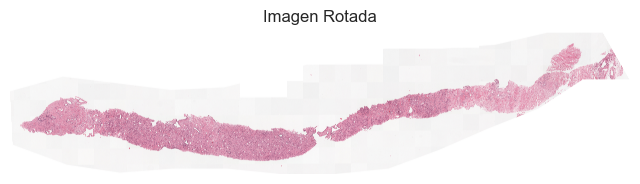

In [15]:
fila = data_rad.loc[data_rad['image_id']=='0018ae58b01bdadc8e347995b69f99aa']
print(fila)

imagen=isup_img[4]
# Rotar la imagen 90° en sentido antihorario
imagen_rotada = cv2.rotate(imagen, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Convertir de BGR a RGB
imagen_rotada = cv2.cvtColor(imagen_rotada, cv2.COLOR_BGR2RGB)

# Mostrar la imagen rotada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rotada)
plt.axis("off")  # Ocultar ejes
plt.title("Imagen Rotada")
plt.show()

La imagen anterior hace parte del conjunto suministrados por Radboud, vemos que esta imagen tiene un gleason score de ``4+4`` lo que significa que en la  biopsia de prostata anterior se encuentra presente un cancer agresivo y se confirma puesto que el grado de ISUP es de ``4``, a simple vista no es simple ver donde se encuentra el cancer, pero como se mencionó al inico de este estudio, el conjunto de datos de entrenamiento cuenta con unas mascaras las cuales nos permiten notar la presencia de cancer tanto a nosotros como al modelo que mas adelante se implementará. 

La imagen se encuentra rotada 90 grados por motivos de mejor visualización.

Dimensiones de la imagen: (25344, 5888)
Tipo de datos: uint8
Valor mínimo: 0
Valor máximo: 4
Valores únicos: [0 1 2 4]


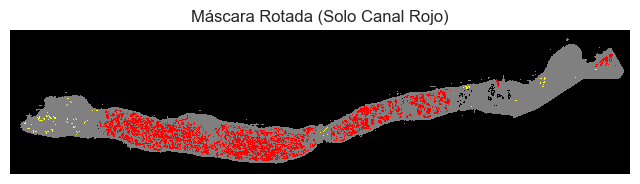

In [ ]:
imagen = isup_mask[4]
imagen = imagen[:, :, 2] 

# Verificar propiedades de la imagen
print("Dimensiones de la imagen:", imagen.shape)
print("Tipo de datos:", imagen.dtype)
print("Valor mínimo:", imagen.min())
print("Valor máximo:", imagen.max())
print("Valores únicos:", np.unique(imagen))

# Rotar la imagen 90° en sentido antihorario
imagen_rotada = cv2.rotate(imagen, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Definir la paleta de colores para las clases
cmap = mcolors.ListedColormap(['black', 'gray', 'yellow', 'red'])

# Mostrar la imagen con la paleta de colores
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rotada, cmap=cmap, interpolation='nearest', vmin=0, vmax=4)
plt.axis("off")
plt.title("Máscara Rotada (Solo Canal Rojo)")
plt.show()


En la imagen anterior se visualixa la mascara correspondiente a la biopsia que se presentó anteriormente, como podemos ver los valores únicos que se encuentran en la mascara son ```0, 1, 2, 4```, lo que indica que las celulas que se encuentran en la biopsia corresponden a celulas de estas clases, que como se mencionó en el contexto es una escala que clasifica las celulas con respecto a su grado de cancer.

```Importante:``` la información de las mascaras se encuentra en el canal rojo de la imagen y se le agrega una paleta de colores para cada clase de las celulas, la mascara anterior en su mayoria es roja, porque existe mayor presencia de celulas cancerigenas, es decir de la clase 4.

A continuación veamos como se ven cada una biopsia que pertenecen a cada uno de los grados de ````ISUP````.

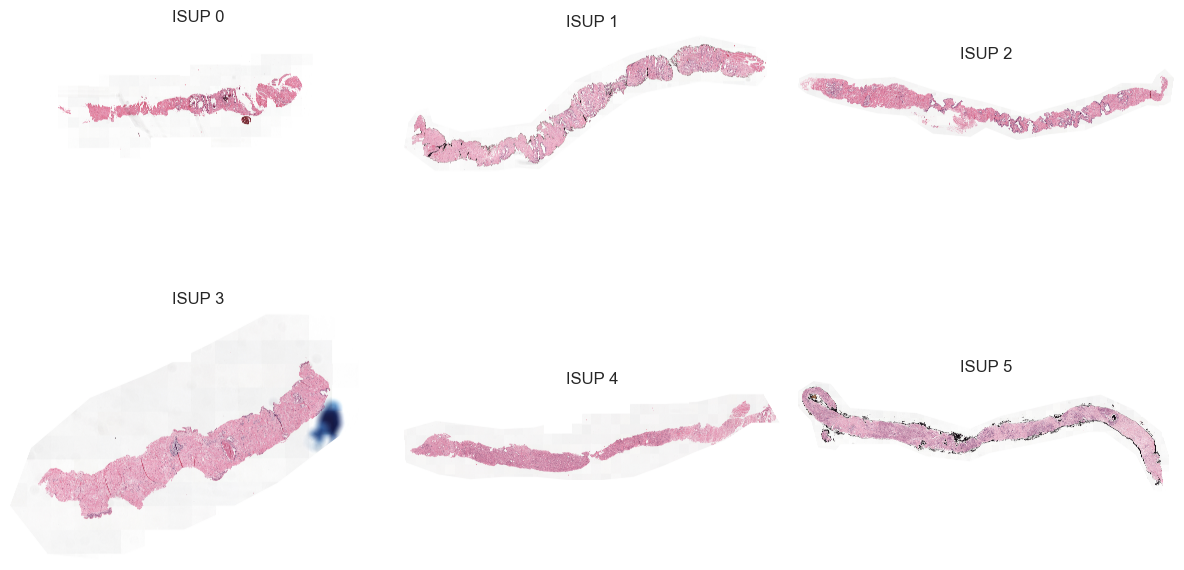

In [ ]:
isup_values = [0, 1, 2, 3, 4, 5]
data_isup = data_rad[data_rad['isup_grade'].isin(isup_values)].groupby('isup_grade').first().reset_index()

# Crear la figura y los subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Recorrer los IDs de las imágenes
for i, row in enumerate(data_isup.itertuples()):
    img_id = row.image_id
    isup_grade = row.isup_grade

    imagen = isup_img[i]

    # Rotar la imagen 90° en sentido antihorario
    imagen_rotada = cv2.rotate(imagen, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # Convertir de BGR a RGB
    imagen_rotada = cv2.cvtColor(imagen_rotada, cv2.COLOR_BGR2RGB)

    # Seleccionar el subplot correspondiente
    ax = axes[i // 3, i % 3]
    ax.imshow(imagen_rotada)
    ax.axis("off")
    ax.set_title(f"ISUP {isup_grade}")

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


Ahora veamos como se ven las mascaras para cada una de las biopsias anteriores.

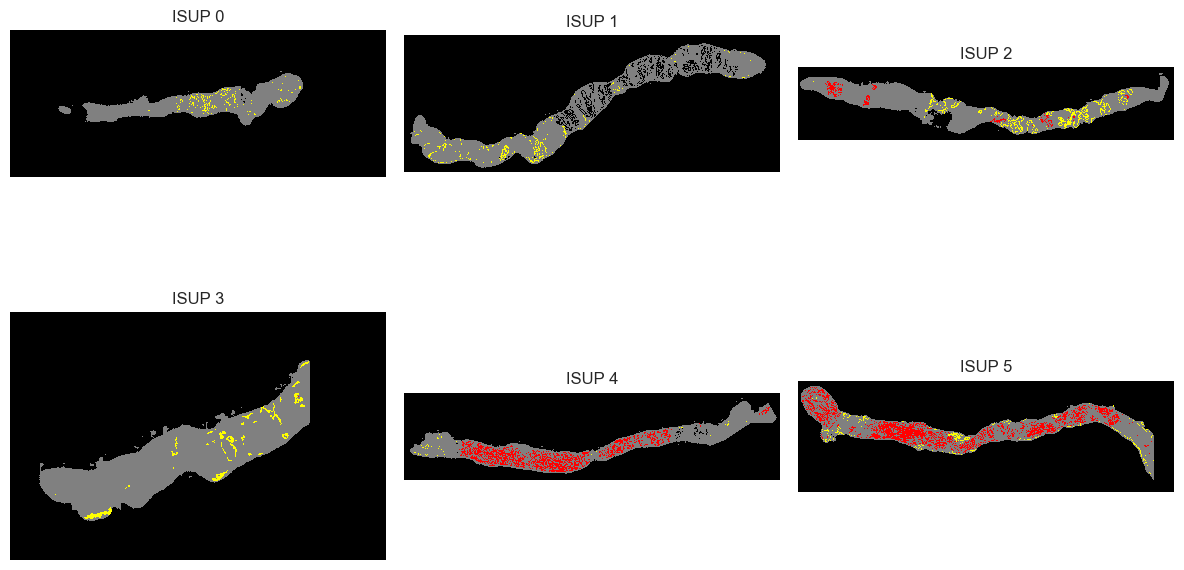

In [41]:
cmap = mcolors.ListedColormap(['black', 'gray', 'yellow', 'red'])

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Recorrer los IDs de las imágenes
for i, row in enumerate(data_isup.itertuples()):
    img_id = row.image_id
    isup_grade = row.isup_grade

    imagen = isup_mask[i]

    # Extraer solo el canal rojo
    imagen = imagen[:, :, 2]

    # Rotar la imagen 90° en sentido antihorario
    imagen_rotada = cv2.rotate(imagen, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Seleccionar el subplot correspondiente
    ax = axes[i // 3, i % 3]
    ax.imshow(imagen_rotada, cmap=cmap, interpolation='nearest', vmin=0, vmax=4)
    ax.axis("off")
    ax.set_title(f"ISUP {isup_grade}")

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


En la imagen anterior donde se muestran las mascaras asociada a cada una de las biopsia anteriores, lo mas interesante es notar como a medida que aumenta el grado de ```ISUP``` el color en las imagenes se va intensificando, indicando que las celulas que hay en cada imagen van aumentando en su prescencia de cancer y el grado del cancer.

### **Caracterización de imagenes**

En esta sección veremos las caracteristicas mas importantes de las imagenes que mas adelante se usarán para entrenar los modelos mas adelante.

Iniciamnos conociendo la distribución del ancho, alto y el radio de las imagenes.

In [19]:
img_prop = {
    "image_id": [],
    "width": [],
    "height": [],
    "aspect_ratio": []
}

for i, imagen in enumerate(isup_img):
    # Obtener dimensiones
    height, width = imagen.shape[:2]

    # Calcular relación de aspecto
    aspect_ratio = width / height

    id=data_isup['image_id'][i]

    # Guardar en el diccionario
    img_prop["image_id"].append(id)
    img_prop["width"].append(width)
    img_prop["height"].append(height)
    img_prop["aspect_ratio"].append(aspect_ratio)

# Convertir a DataFrame
image_data = pd.DataFrame(img_prop)

# Mostrar algunas filas
image_data.head(6)


,image_id,width,height,aspect_ratio
0,007433133235efc27a39f11df6940829,9472,24320,0.389474
1,004dd32d9cd167d9cc31c13b704498af,8192,22528,0.363636
2,00bbc1482301d16de3ff63238cfd0b34,5120,26624,0.192308
3,0068d4c7529e34fd4c9da863ce01a161,6912,10496,0.658537
4,0018ae58b01bdadc8e347995b69f99aa,5888,25344,0.232323
5,00928370e2dfeb8a507667ef1d4efcbb,10752,36352,0.295775


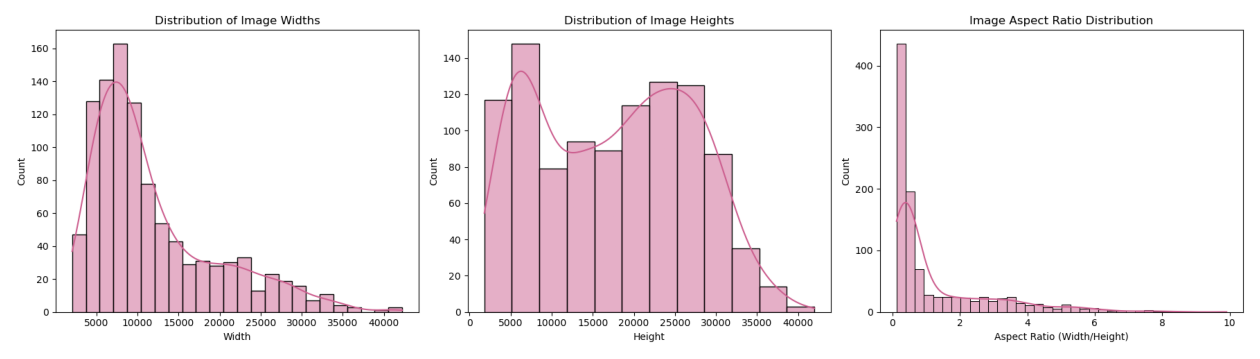

In [16]:
imagen = mpimg.imread("DimensionPlot.png")

# Mostrar la imagen
plt.figure(figsize=(16, 12))  
plt.imshow(imagen)
plt.axis("off")  # Oculta los ejes
plt.show()

Se observa que la mayoría de las imágenes tienen anchos entre 5,000 y 15,000 píxeles, con una distribución sesgada a la derecha y algunos valores extremos. La distribución de alturas presenta una forma bimodal, indicando la presencia de dos grupos principales de tamaños. En cuanto a la relación de aspecto, la mayoría de las imágenes tienen valores cercanos a 1, sugiriendo formatos cuadrados, mientras que pocas presentan relaciones de aspecto altas, lo que indica que imágenes extremadamente anchas son poco comunes. En general, el conjunto de imágenes es diverso en tamaño, pero con ciertas tendencias predominantes.

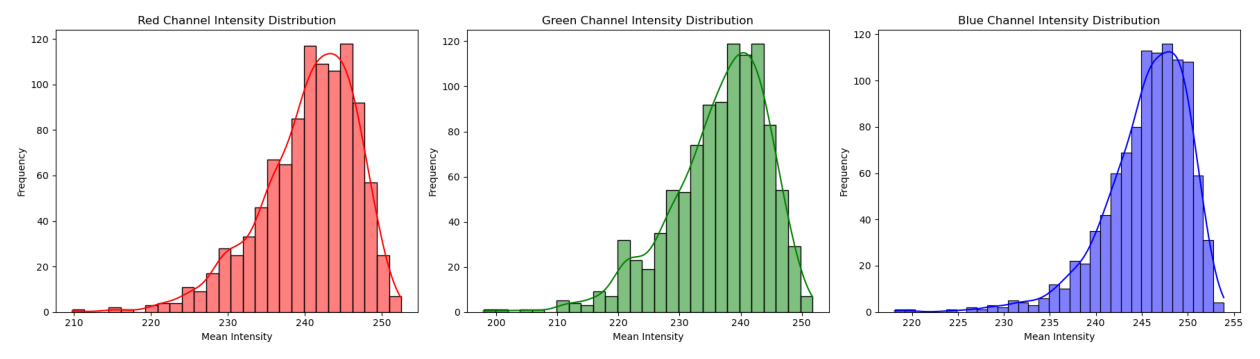

In [15]:
imagen = mpimg.imread("ColorChannelIntensity.png")

# Mostrar la imagen
plt.figure(figsize=(16, 12))  
plt.imshow(imagen)
plt.axis("off")  # Oculta los ejes
plt.show()

Las gráficas muestran la distribución de la intensidad media en los canales de color rojo, verde y azul de un conjunto de imágenes. En los tres casos, la distribución es asimétrica hacia la izquierda, con una mayor concentración de valores altos, lo que sugiere que predominan colores claros en las imágenes analizadas. El canal azul presenta una mayor acumulación en intensidades cercanas a 250, mientras que los canales rojo y verde muestran distribuciones más extendidas con picos alrededor de 240. Esto indica que los tonos azulados podrían ser más predominantes en la composición cromática de las imágenes.

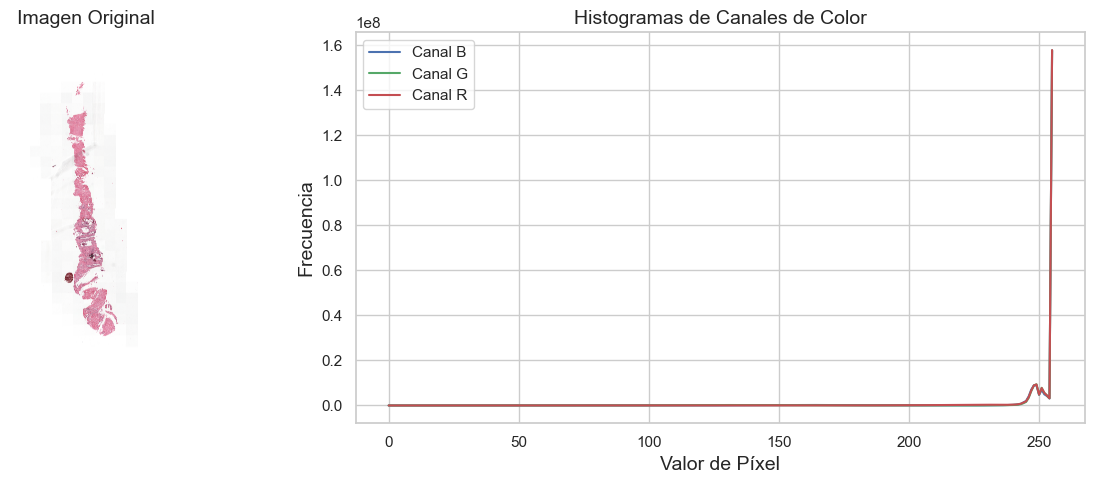

In [ ]:
color_image = isup_img[0]  # Puedes cambiar el índice si quieres otra imagen

# Calcular histogramas de los tres canales (BGR)
color_histograms = [cv2.calcHist([color_image], [i], None, [256], [0, 256]) for i in range(3)]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Mostrar la imagen original
axs[0].imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Imagen Original', fontsize=14)
axs[0].axis('off')

# Graficar histogramas de color
colors = ['b', 'g', 'r']
for hist, color in zip(color_histograms, colors):
    axs[1].plot(hist, color=color, label=f'Canal {color.upper()}')

axs[1].set_title('Histogramas de Canales de Color', fontsize=14)
axs[1].set_xlabel('Valor de Píxel', fontsize=14)
axs[1].set_ylabel('Frecuencia', fontsize=14)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Según la información entregada por la figura aneterior, se muestra una predominancia de tonos rosados y rojos, lo que se refleja en el histograma con un pico alto en el canal R (rojo), indicando una gran presencia de colores claros o blancos en la imagen. Los canales G (verde) y B (azul) tienen frecuencias mucho menores, sugiriendo que la imagen tiene una dominancia rojiza, típica en imágenes histológicas y en este caso patológicas como lo son estas biopsias.

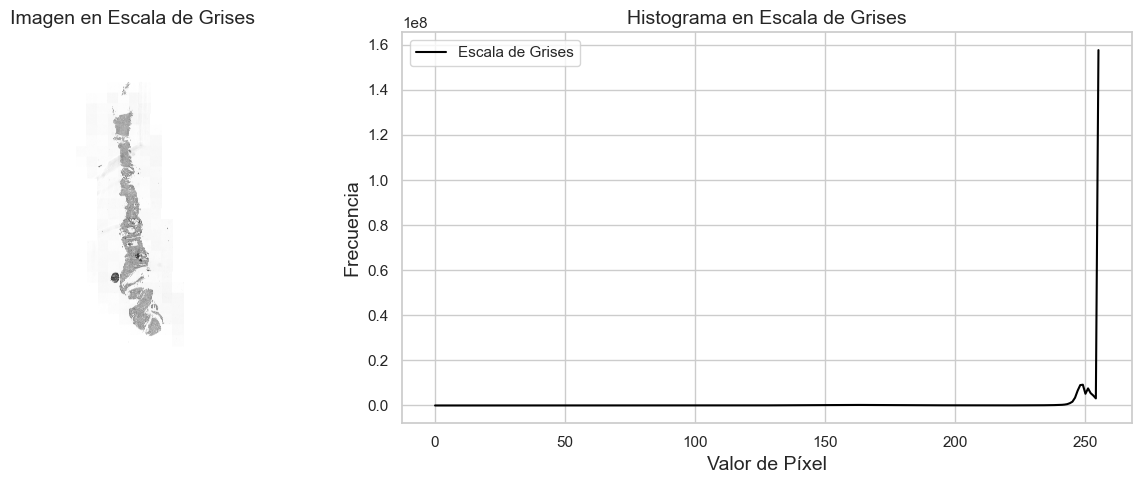

In [28]:
gray_image = cv2.cvtColor(isup_img[0], cv2.COLOR_BGR2GRAY)

# Calcular histograma en escala de grises
gray_hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Mostrar la imagen en escala de grises
axs[0].imshow(gray_image, cmap='gray')
axs[0].set_title('Imagen en Escala de Grises', fontsize=14)
axs[0].axis('off')

# Graficar histograma en escala de grises
axs[1].plot(gray_hist, color='black', label='Escala de Grises')
axs[1].set_title('Histograma en Escala de Grises', fontsize=14)
axs[1].set_xlabel('Valor de Píxel', fontsize=14)
axs[1].set_ylabel('Frecuencia', fontsize=14)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Como adición del analisis anterior, se entrega la imagen anterior donde se muestra un histograma en escala de grises complementa el análisis de la imagen anterior. Muestra que la mayoría de los píxeles tienen valores cercanos a 255, lo que indica una gran presencia de áreas blancas o casi blancas en la imagen. Esto sugiere que la imagen tiene un fondo claro con regiones más oscuras que representan las estructuras principales.